#**M-dwarfs and the Galactic Clock: A New Way to Trace the Milky Way’s Star Formation History**

#By Kinsey Cronin, Taylor Gudebski, and Maya Maaloul

###In this project, we investigate how the relationship between [Mg/Fe] and [Fe/H] in M-Dwarf stars informs our understanding of the star formation history of our local universe. For this research, we used high-quality chemical abundance measurements of 12,282 M-dwarfs obtained from the M-Dwarfs Catalog database (Behmard et al. 2025). The following notebook walks through all the data cleaning, analysis, and plotting used to obtain our results.


##1. Import Necessary Libraries

In [ ]:
    #Install the necessary MCMC packages
    !pip install emcee
    !pip install corner

In [ ]:
# Importing useful libraries
import math as math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import emcee
import corner
from scipy import stats
import matplotlib.patches as mpatches

##2. Cleaning Data

The following data is from the M-Dwarf Catalog database compiled from Behmard et al. 2025. We started with a their 16,590 M-Dwarf stars and after cleaning were left with 12,282 stars. All columns, but those relevant to our research(source id, name, [Fe/H], [Mg/H], [O/H], and errors for these compositions), were removed from our dataset as well as any NaNs from these columns.

In [ ]:
#import drive and read in the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
dataraw = pd.read_csv('/content/drive/MyDrive/Mdwarfcatalog.csv')
dataraw

Mounted at /content/drive


,gaia_dr3_source_id,name,Teff_cannon,fe_h_cannon,mg_h_cannon,al_h_cannon,si_h_cannon,c_h_cannon,o_h_cannon,ca_h_cannon,...,mg_h_err,al_h_err,si_h_err,c_h_err,o_h_err,ca_h_err,ti_h_err,cr_h_err,n_h_err,ni_h_err
0,421503353090268416,54381371,3814.648562,-0.002649,0.025642,0.054333,0.022201,0.018351,-0.018559,0.015455,...,0.024966,0.024770,0.021992,0.029377,0.024694,0.022268,0.028546,0.027592,0.031801,0.020787
1,421535342004177920,54381716,3830.414302,-0.062153,-0.045996,-0.099535,-0.070917,-0.049312,-0.075825,-0.033821,...,0.023589,0.023671,0.020938,0.028094,0.023375,0.021150,0.027873,0.026605,0.030782,0.019752
2,421917594095590272,54386478,3382.336704,0.035759,0.138505,0.166984,0.055149,0.119456,0.062212,0.034238,...,0.019298,0.019771,0.017259,0.024733,0.020225,0.017767,0.024690,0.023697,0.027700,0.016265
3,422026445746556928,54387723,3602.579561,0.158492,0.158258,0.214966,0.156961,0.181329,0.097641,0.174604,...,0.020711,0.020998,0.018450,0.025864,0.021335,0.018930,0.025620,0.024696,0.028686,0.017442
4,422148079220822912,54389138,3792.402877,-0.058642,-0.035401,-0.051198,-0.042038,-0.136078,-0.061466,-0.040392,...,0.020461,0.020808,0.018260,0.025637,0.021088,0.018721,0.025568,0.024576,0.028490,0.017242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16585,3209578040384913536,129059983,3151.019947,-0.149371,0.121522,-0.009253,-0.077171,0.135365,0.005518,-0.070330,...,0.025794,0.025639,0.022725,0.029683,0.025099,0.022802,0.029138,0.027845,0.032246,0.021388
16586,3017239848568923520,129060047,3148.192367,-0.026532,0.204838,0.149194,0.052169,0.182282,0.158149,0.032916,...,0.021692,0.021918,0.019272,0.026494,0.021964,0.019635,0.026269,0.025172,0.029292,0.018158
16587,3130454018259106048,129060239,3905.065337,-0.076273,0.032047,-0.187530,-0.080724,0.220038,-0.026964,0.048419,...,0.022018,0.022265,0.019596,0.026870,0.022222,0.019964,0.026494,0.025473,0.029610,0.018527
16588,5965992737047976192,129060609,4056.107705,-0.056331,-0.017486,-0.368082,-0.115424,0.233261,0.004577,0.084797,...,0.023596,0.023593,0.020882,0.028083,0.023618,0.021267,0.027586,0.026520,0.030740,0.019701


In [ ]:
#Remove all columns except source id, name, fe/h, mg/h, o/h, and errors.
data = dataraw
for col in data.columns:
    if col not in ['gaia_dr3_source_id', 'name', 'fe_h_cannon', 'mg_h_cannon', 'fe_h_err', 'mg_h_err',"o_h_cannon", "o_h_err", "Teff_cannon"]:
        data.drop(col, axis=1, inplace=True)

#No NaNs so unnecesary
data = data.dropna(subset=['fe_h_cannon', 'mg_h_cannon'])
data["convective"]= np.where(data["Teff_cannon"]<3400, 1, 0)

#Add columns for mg/fe and mg/fe errors
mgfe=data['mg_h_cannon']-data['fe_h_cannon']
data['mgfe']=mgfe
#propogating errors
data["mgfe_err"]=np.sqrt(data["fe_h_err"]**2+data["mg_h_err"]**2)
#limit data to only those with errors less than 0.03 (providing a more precise dataset)
data = data[data['mgfe_err'] <= 0.03]
data= data[data["fe_h_err"]<=0.03]
#Add columns for o/fe and o/fe errors
ofe=dataraw['o_h_cannon']-dataraw['fe_h_cannon']
data['ofe']=ofe
data["ofe_err"]=np.sqrt(data["fe_h_err"]**2+data["o_h_err"]**2)

data

,gaia_dr3_source_id,name,Teff_cannon,fe_h_cannon,mg_h_cannon,o_h_cannon,fe_h_err,mg_h_err,o_h_err,convective,mgfe,mgfe_err,ofe,ofe_err
2,421917594095590272,54386478,3382.336704,0.035759,0.138505,0.062212,0.015765,0.019298,0.020225,1,0.102746,0.024919,0.026453,0.025644
3,422026445746556928,54387723,3602.579561,0.158492,0.158258,0.097641,0.016952,0.020711,0.021335,0,-0.000234,0.026764,-0.060851,0.027250
4,422148079220822912,54389138,3792.402877,-0.058642,-0.035401,-0.061466,0.016719,0.020461,0.021088,0,0.023242,0.026423,-0.002824,0.026912
5,422204253090333824,54389783,3279.574767,-0.026528,0.032438,-0.013743,0.016428,0.020112,0.020837,1,0.058966,0.025969,0.012785,0.026534
7,422491023770086528,54392812,3755.349314,-0.048599,-0.008981,-0.044188,0.015922,0.019497,0.020357,0,0.039618,0.025172,0.004411,0.025844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16577,3868452927266052864,129058295,3833.441722,-0.260591,-0.273745,-0.272926,0.017720,0.021662,0.021978,0,-0.013154,0.027986,-0.012335,0.028232
16579,527449471742340864,129058514,3927.778542,-0.221996,-0.194622,-0.192692,0.017570,0.021393,0.021793,0,0.027374,0.027683,0.029304,0.027993
16583,2176684683973040640,129059558,3994.751582,-0.075253,0.057468,-0.006137,0.018812,0.023095,0.023128,0,0.132721,0.029787,0.069116,0.029813
16586,3017239848568923520,129060047,3148.192367,-0.026532,0.204838,0.158149,0.017709,0.021692,0.021964,1,0.231369,0.028003,0.184681,0.028213


##3. Initial Plot

To understand the data we are working with, we first created a scatter plot of the stars, and to make it easier to see the distribution of the data, we plotted a kde plot overtop.

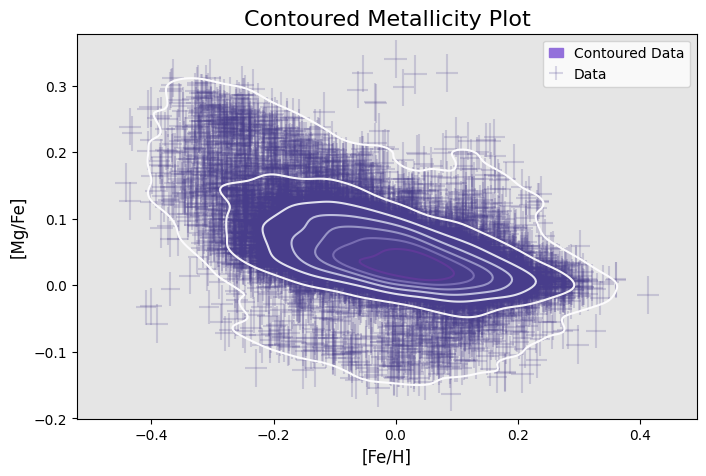

In [ ]:
#Plot an errorbar scatterplot for [Mg/Fe] over [Fe/H]
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5') #change background color to make outer contours more visible
#plot data with errorbars
plt.errorbar(data['fe_h_cannon'], data['mgfe'], xerr=data['fe_h_err'], yerr=data['mgfe_err'],color="darkslateblue", fmt='none', alpha=0.2, label = "Data")
#plot contour lines over the errorbar scatterplot to better see the shape of the data
sns.kdeplot(x=data['fe_h_cannon'],y=data['mgfe'],fill=False, cmap="Purples", levels=8, thresh=0.01, alpha = 1, zorder = 3)
plt.xlabel('[Fe/H]', fontsize = 12)
plt.ylabel('[Mg/Fe]', fontsize = 12)
plt.title('Contoured Metallicity Plot', fontsize = 16)
#create legend for contour plot
kde_patch = mpatches.Patch(color='mediumpurple', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.show()

##4. Creating a Fit

Since stars retain the chemical signatures of the molecular cloud from which they formed, studying these signatures and how they change over time can provide insight into their star forming regions. When stars are created shortly after a supernova, they tend to have higher levels of iron (Fe) in their composition. Over time, as supernovae occur, newly formed stars will show increasing iron abundance. Thus, iron abundances can be used as a psuedo-timeline.

Magnesium (Mg) is produced almost exclusively in core-collapse supernovae (the explosive deaths of massive stars), which happen soon after star formation. In contrast, iron is produced in both core-collapse supernovae and in Type Ia supernovae. Type Ia supernovae occur on much longer timescales, as they are the explosions of white dwarfs, which are the compact cores of dead main sequence stars.

Changes in specific elemental abundances like Mg give us insight into star formation history, by **fitting a piecewise function** to our data, we can identify these points where the slope changes, and thus we can identify changes in these star forming regions.

To do so, we binned our data, condensing it to 8 datapoints, to make its trends more apparent. We then used python's scipy curve_fit function to find a best fit linear piecewise and plotted it with both our unbinned and binned data. Next, we calculated a reduced chi-squared value to validate our fit.

In [ ]:
#Create function to bin the data
def bin_data(x, y, bin_width=0.1, leastbin=10):
    """
    Bin the y-data as a function of x into fixed-width bins and compute statistics for each bin.

    Parameters
    ----------
    x : array-like
        The independent variable to bin by.
    y : array-like
        The dependent variable to compute statistics on.
    bin_width : float, optional
        The width of each bin in the x-direction (default is 0.1).
    leastbin : float, optional
        The smallest number of datapoints in a bin needed for the bin to returned (default is 10).

    Returns
    -------
    bin_centers : ndarray
        The centers of the bins that contain more than 10 data points.
    bin_means : ndarray
        The mean of y-values in each bin (only bins with >10 data points).
    bin_std : ndarray
        The standard deviation of y-values in each bin (only bins with >10 data points).
    bin_edges : ndarray
        The full array of bin edges used in the binning.

    Notes
    -----
    Bins with 10 or fewer data points are excluded from the returned bin statistics.
    This helps avoid noisy or unreliable estimates in sparsely populated bins.
    """
    min_edge = np.floor(np.min(x))
    max_edge = np.ceil(np.max(x))
    bin_edges = np.arange(min_edge, max_edge + bin_width, bin_width)
    bin_means, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)
    bin_std, _, _ = stats.binned_statistic(x, y, statistic='std', bins=bin_edges)
    bin_counts, _, _ = stats.binned_statistic(x, y, statistic='count', bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mask = bin_counts > leastbin
    return bin_centers[mask], bin_means[mask], bin_std[mask], bin_edges

In [ ]:
#Create a function to evaluate a linear function
def linear(x,m,b):
  """
    Evaluate a linear function y = m*x + b.

    Parameters
    ----------
    x : array-like or float
        Input value(s) where the function is evaluated.
    m : float
        Slope of the line.
    b : float
        Y-intercept of the line.

    Returns
    -------
    y : array-like or float
        Output value(s) of the linear function.
  """
  return m*x+b

In [ ]:
#Create piecewise function
def piecewise_linear(x, x0, y0, k1, k2):
    """
    Evaluate a piecewise linear function with a breakpoint.

    The function has two linear segments with different slopes, joined at the breakpoint (x0, y0).
    For x < x0, the slope is k1.
    For x >= x0, the slope is k2.

    Parameters
    ----------
    x : array-like or float
        Input value(s) at which to evaluate the function.
    x0 : float
        X-coordinate of the breakpoint.
    y0 : float
        Y-coordinate of the breakpoint.
    k1 : float
        Slope of the line for x < x0.
    k2 : float
        Slope of the line for x >= x0.

    Returns
    -------
    y : array-like or float
        Output value(s) of the piecewise linear function.
    """
    return np.where(x < x0, y0 + k1 * (x - x0), y0 + k2 * (x - x0))

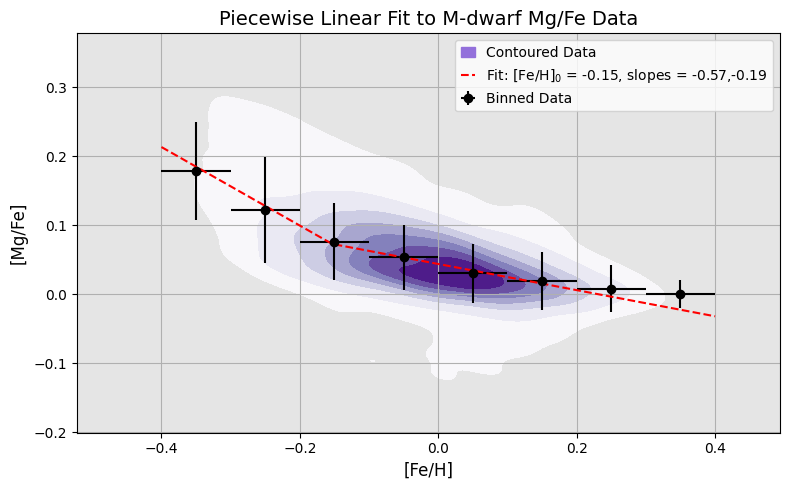

In [ ]:
# Initial guess
p0 = [0.0, 0.05, -0.5, -0.1]

# Fit the model to data
popt, pcov = curve_fit(piecewise_linear,data['fe_h_cannon'],data['mgfe'], sigma=data['mgfe_err'],absolute_sigma=True,p0=p0)

#create the bins
bin_centers, bin_means, bin_std, bin_edges = bin_data(data["fe_h_cannon"], data["mgfe"], bin_width=0.1, leastbin=20)

# create the best fit line within the linespace of the data
x_fit = np.linspace(-0.4, 0.4, 1000)
y_fit = piecewise_linear(x_fit, *popt)

# Plot a errorbar scatter plot of the data and plot the least squares fit on top
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5')

#plot kde using seaborn package to see the distribution of the data
sns.kdeplot(x=data['fe_h_cannon'],y=data['mgfe'],fill=True,cmap="Purples", levels=8, label = "Contoured Data", legend = True)
plt.errorbar(bin_centers, bin_means,xerr=0.05, yerr=bin_std, fmt='o',color="black", alpha=1, label='Binned Data', zorder=100)
plt.plot(x_fit, y_fit, label=rf"Fit: $[{{\rm Fe}}/{{\rm H}}]_0$ = {popt[0]:.2f}, slopes = {popt[2]:.2f},{popt[3]:.2f}",linestyle="--", color='red', zorder=100)
plt.xlabel("[Fe/H]", fontsize = 12)
plt.ylabel("[Mg/Fe]", fontsize = 12)
plt.title("Piecewise Linear Fit to M-dwarf Mg/Fe Data", fontsize = 14)
kde_patch = mpatches.Patch(color='mediumpurple', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

To confirm our fit, we ran an MCMC simulation using the curve_fit parameters as our initial guess.

In [ ]:
#The set up for the MCMC simulation

# Log-likelihood
def ln_likelihood(theta, x, y, yerr):
    """
    Calculate the log-likelihood of the model given the data.

    Parameters
    ----------
    theta : array_like
        Model parameters ([x0, y0, k1, k2] for the piecewise linear function.)
    x : array_like
        Independent variable data (e.g., [Fe/H] values).
    y : array_like
        Dependent variable data (e.g., [Mg/Fe] values).
    yerr : array_like
        Uncertainties in the dependent variable.
    Returns
    -------
    float
        Log-likelihood value assuming Gaussian errors.
    """
    x0, y0, k1, k2 = theta
    model = piecewise_linear(x, x0, y0, k1, k2)
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

# Log-prior
def ln_prior(theta):
    """
    Evaluate the log-prior probability of the model parameters.

    Parameters
    ----------
    theta : array_like
        Model parameters ([x0, y0, k1, k2]).

    Returns
    -------
    float
        Log-prior probability. Returns 0.0 for parameters within specified bounds,
        and -infinity otherwise to reject unphysical models.
    """
    x0, y0, k1, k2 = theta
    if -0.5 < x0 < 0.5 and -0.1 < y0 < 1 and -5 < k1 < 5 and -5 < k2 < 5:
        return 0.0
    return -np.inf

# Log-probability
def ln_probability(theta, x, y, yerr):
    """
    Compute the total log-probability (prior + likelihood) for the model parameters.

    Parameters
    ----------
    theta : array_like
        Model parameters ([x0, y0, k1, k2]).
    x : array_like
        Independent variable data (e.g., [Fe/H] values).
    y : array_like
        Dependent variable data (e.g., [Mg/Fe] values).
    yerr : array_like
        Uncertainties in the dependent variable.

    Returns
    -------
    float
        Total log-probability. If the prior is invalid, returns -infinity; otherwise,
        returns the sum of log-prior and log-likelihood.
    """
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(theta, x, y, yerr)


# Initial guess from curve_fit
initial = np.array([-0.15, 0.07, -0.50, -0.20])
# Set the number of dimensions (parameters) and number of MCMC walkers
ndim, nwalkers = 4, 100  # 4 parameters to fit, and 100 walkers exploring parameter space

# Initialize the starting positions of each walker near the initial guess
# Each walker's starting position is randomly perturbed from the initial guess
pos = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [ ]:
#Run MCMC for Mg
# The sampler will use the defined log-probability function (ln_probability)
# and the data arrays for [Fe/H], [Mg/Fe], and their uncertainties
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(data["fe_h_cannon"], data["mgfe"], data['mgfe_err']))

# Run the MCMC chains starting from the initial positions
# Here, 1000 steps are taken for each walker
sampler.run_mcmc(pos, 1000, progress=True)

# After the MCMC run, discard the first 100 steps as "burn-in" (to remove initial bias)
# Thin the chain by keeping every 15th sample to reduce autocorrelation
# Flatten all walkers into a single array of samples
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


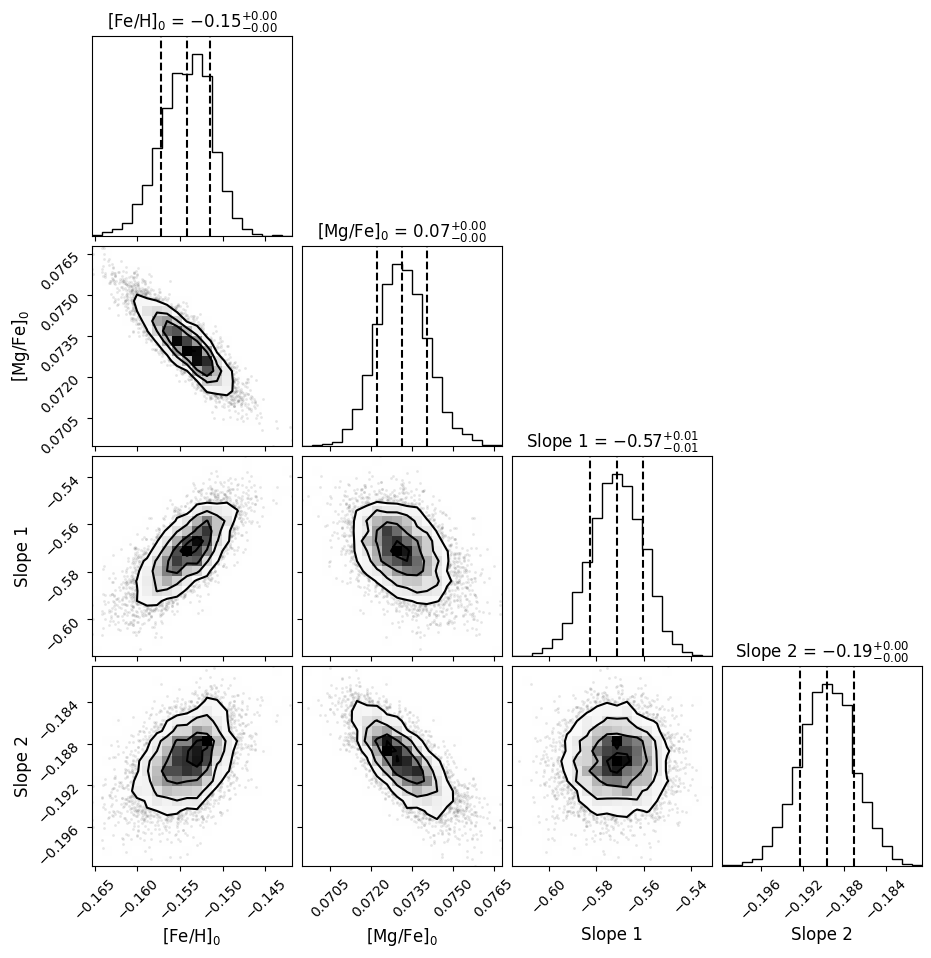

In [ ]:
# Create a corner plot of the posterior distributions
# This shows the marginalized distributions for each parameter and their covariances
corner.corner(flat_samples, labels=[r"[Fe/H]$_0$", r"[Mg/Fe]$_0$", "Slope 1", "Slope 2"], quantiles=[0.16,0.5,0.84], show_titles=True, plot_quantiles=True, label_kwargs={"size":12})
plt.show()

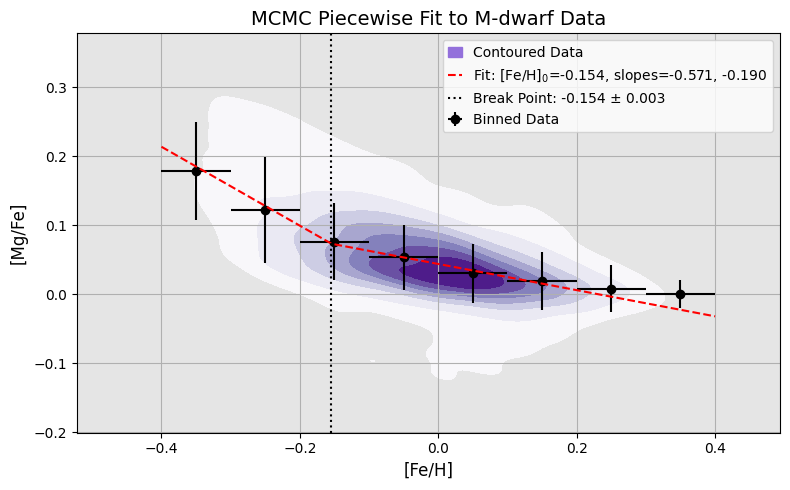

Mean break point: -0.154 ± 0.003


In [ ]:
#Find initial values for MCMC
x0_mcmc, y0_mcmc, k1_mcmc, k2_mcmc = np.median(flat_samples, axis=0)
x_fit = np.linspace(-0.4, 0.4, 1000)
y_fit = piecewise_linear(x_fit, x0_mcmc, y0_mcmc, k1_mcmc, k2_mcmc)
bin_centers, bin_means, bin_std, bin_edges = bin_data(data["fe_h_cannon"], data["mgfe"], bin_width=0.1, leastbin=20)

#create figure
plt.figure(figsize=(8,5))
plt.gca().set_facecolor('#E5E5E5')
#plot kde
sns.kdeplot(x=data['fe_h_cannon'],y=data['mgfe'],fill=True,cmap="Purples", levels=8, label = "Data", legend = True)
#plot piecewise line of best fit
plt.plot(x_fit, y_fit, color='red', linestyle="--", label=f"Fit: [Fe/H]$_0$={x0_mcmc:.3f}, slopes={k1_mcmc:.3f}, {k2_mcmc:.3f}", zorder=100)
#plot binned data
plt.errorbar(bin_centers, bin_means,xerr=0.05, yerr=bin_std, fmt='o',color="black", alpha=1, label='Binned Data', zorder=2)

#Calculate break point for piecewise
break_points=flat_samples[:,0]
lower, upper = np.percentile(break_points, [15, 84])
errormg = np.std(break_points)
mean_break_mg = np.mean(break_points)

#plot line at break point
plt.axvline(mean_break_mg, color='black', linestyle=':', label=f"Break Point: {mean_break_mg:.3f} ± {errormg:.3f}", zorder=101)
plt.xlabel("[Fe/H]", fontsize = 12)
plt.ylabel("[Mg/Fe]", fontsize = 12)
plt.title("MCMC Piecewise Fit to M-dwarf Data", fontsize = 14)
#Add kde plot into legend
kde_patch = mpatches.Patch(color='mediumpurple', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.grid(True) #add background grid to graph
plt.tight_layout()
plt.show()

print(f"Mean break point: {mean_break_mg:.3f} ± {errormg:.3f}")

In [ ]:
#create the y values from the model
y_model = piecewise_linear(data['fe_h_cannon'], x0_mcmc, y0_mcmc, k1_mcmc, k2_mcmc)

# Compute chi-squared
chi_squared = np.sum(((data['mgfe'] - y_model) / data['mgfe_err'])**2)
# Compute degrees of freedom: number of data points - number of fitted parameters
dof = len(data['fe_h_cannon']) - 4

# Compute reduced chi-squared
reduced_chi_squared = chi_squared / dof
print(f"Reduced chi-squared: {reduced_chi_squared:.5f}")

Reduced chi-squared: 3.26760


<ipython-input-15-85645b984571>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(data["fe_h_cannon"], residuals,xerr=data["fe_h_err"], yerr=data["mgfe_err"], fmt=".k", alpha=0.3, color="darkslateblue")


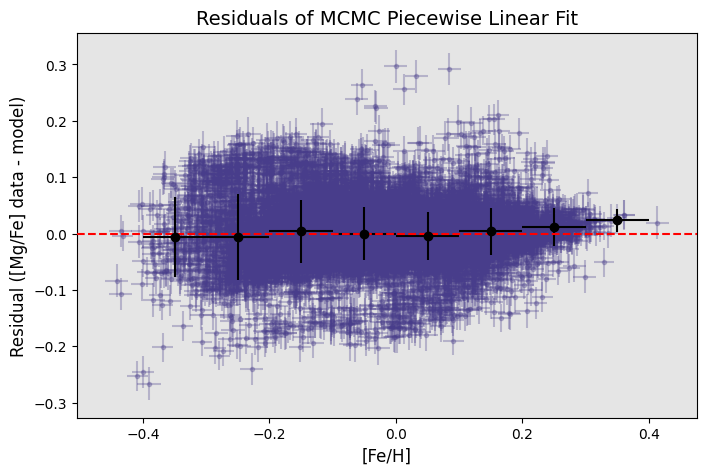

In [ ]:
# Residuals = data - model
residuals = data["mgfe"] - y_model

#Create model for binned residuals
model_at_bins = piecewise_linear(bin_centers, x0_mcmc, y0_mcmc, k1_mcmc, k2_mcmc)
# Residuals for binned data
binned_residuals = bin_means - model_at_bins

# Plot
plt.figure(figsize=(8,5))
plt.gca().set_facecolor('#E5E5E5')

# Main residuals plot with binned and nonbinned data
plt.errorbar(data["fe_h_cannon"], residuals,xerr=data["fe_h_err"], yerr=data["mgfe_err"], fmt=".k", alpha=0.3, color="darkslateblue")
plt.errorbar(bin_centers, binned_residuals,xerr=0.05, yerr=bin_std, fmt='o', color="black", label='Binned residuals', zorder=100)
plt.axhline(0, color="red", linestyle="--", zorder=100)  # Line at 0 for reference
plt.xlabel("[Fe/H]", fontsize = 12)
plt.ylabel("Residual ([Mg/Fe] data - model)", fontsize = 12)
plt.title("Residuals of MCMC Piecewise Linear Fit", fontsize = 14)
plt.show()

##4.  Validating our results
To validate our results, we ran the same MCMC simulation with [O/Fe]. As oxygen production is similar to magnesium, our piecewise function should be very similar and we should see a change in slope at nearly the same place as [Mg/Fe] (at a mean break point of -0.154 ± 0.003).

In [ ]:
# Initial guess
p0 = [-0.15, 0.05, -0.5, -0.1]
# Fit the model to data
samplero = emcee.EnsembleSampler(nwalkers, ndim, ln_probability, args=(data["fe_h_cannon"], data["ofe"], data['ofe_err']))
samplero.run_mcmc(pos, 1000, progress=True)
flat_sampleso = samplero.get_chain(discard=100, thin=15, flat=True)

100%|██████████| 1000/1000 [02:48<00:00,  5.92it/s]


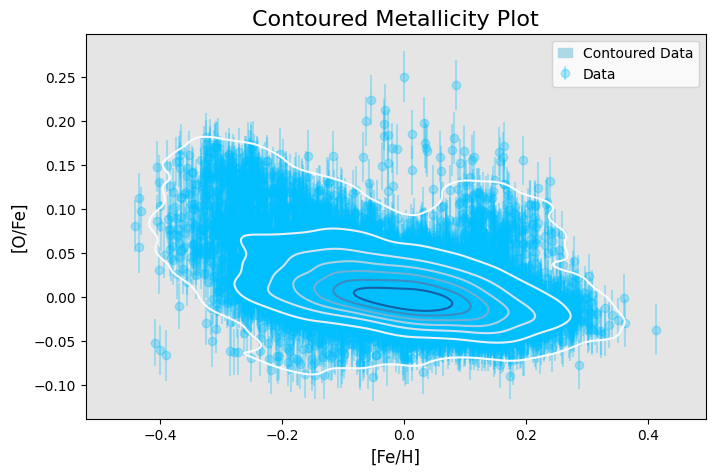

In [ ]:
#Get initial values for mcmc
x0_mcmco, y0_mcmco, k1_mcmco, k2_mcmco = np.median(flat_sampleso, axis=0)
x_fito = np.linspace(-0.4, 0.4, 1000)
y_fit_mcmc = piecewise_linear(x_fito, x0_mcmco, y0_mcmco, k1_mcmco, k2_mcmco)
#bin the data
bin_centers_o, bin_means_o, bin_std_o, bin_edges_o = bin_data(data["fe_h_cannon"], data["ofe"], bin_width=0.1, leastbin=20)

#Plot an errorbar scatterplot for [O/Fe] over [Fe/H] with contour plot overlayed
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5')
plt.errorbar(data['fe_h_cannon'], data['ofe'], yerr=data['ofe_err'], fmt='o', color="deepskyblue", alpha=0.3, label='Data')
sns.kdeplot(x=data['fe_h_cannon'],y=data['ofe'],fill=False, cmap="Blues", levels=8, thresh=0.01, alpha = 1, zorder = 3)
plt.xlabel('[Fe/H]', fontsize = 12)
plt.ylabel('[O/Fe]', fontsize = 12)
plt.title('Contoured Metallicity Plot', fontsize = 16)
kde_patch = mpatches.Patch(color='lightblue', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.show()

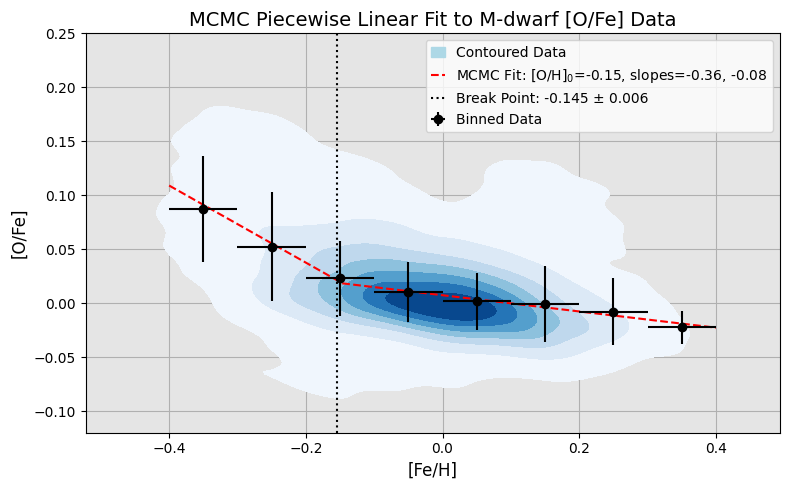

Mean break point: -0.145 ± 0.006


In [ ]:
# Plot a errorbar scatter plot of the data and plot the least squares fit on top
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5')
sns.kdeplot(x=data['fe_h_cannon'],y=data['ofe'],fill=True, cmap="Blues", levels=8, thresh=0.01, alpha = 1, zorder = 3)
plt.plot(x_fito, y_fit_mcmc, label=f"MCMC Fit: [O/H]$_0$={x0_mcmco:.2f}, slopes={k1_mcmco:.2f}, {k2_mcmco:.2f}", color='red', linestyle="--",zorder=100)
plt.errorbar(bin_centers_o, bin_means_o,xerr=0.05, yerr=bin_std_o, fmt='o',color="black", alpha=1, label='Binned Data', zorder=100)

#Calculate break point in piecewise
break_points=flat_sampleso[:,0]
lower, upper = np.percentile(break_points, [15, 84])
erroro = np.std(break_points)
mean_break_o = np.mean(break_points)

#plot line at break point
plt.axvline(mean_break_mg, color='black', linestyle=':', label=f"Break Point: {mean_break_o:.3f} ± {erroro:.3f}", zorder=101)
plt.xlabel("[Fe/H]", fontsize = 12)
plt.ylabel("[O/Fe]", fontsize = 12)
plt.title("MCMC Piecewise Linear Fit to M-dwarf [O/Fe] Data", fontsize = 14)
kde_patch = mpatches.Patch(color='lightblue', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.12, 0.25)
plt.show()

print(f"Mean break point: {mean_break_o:.3f} ± {erroro:.3f}")

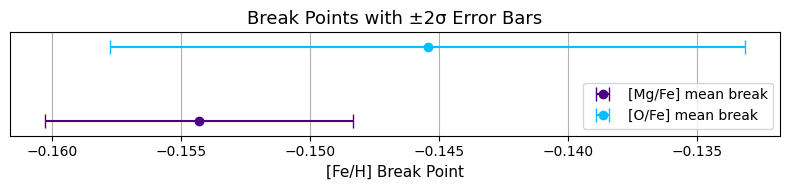

In [ ]:
#Visualizing mean break points overlap to ±2σ
x = [0, 1]
means = [mean_break_mg, mean_break_o]
errors = [errormg, erroro]

plt.figure(figsize=(8, 2))
plt.errorbar(means[0], 0, xerr=errors[0]*2, fmt='o', color='indigo', label='[Mg/Fe] mean break', capsize=5)
plt.errorbar(means[1], 1, xerr=errors[1]*2, fmt='o', color='deepskyblue', label='[O/Fe] mean break', capsize=5)

# Clean up plot
plt.yticks([], [])  # Remove y-axis ticks
plt.xlabel('[Fe/H] Break Point', fontsize = 11)
plt.title('Break Points with ±2σ Error Bars', fontsize = 13)
plt.legend(loc = "lower right")
plt.grid(True, axis='x')
plt.ylim(-0.2, 1.2)
plt.tight_layout()
plt.show()

To check our fit further, we also fitted a linear function to the data (instead of a piecewise) and calculated the reduced chi squared value for the line. We compared it to the piecewise chi-squared to see which was a better fit.

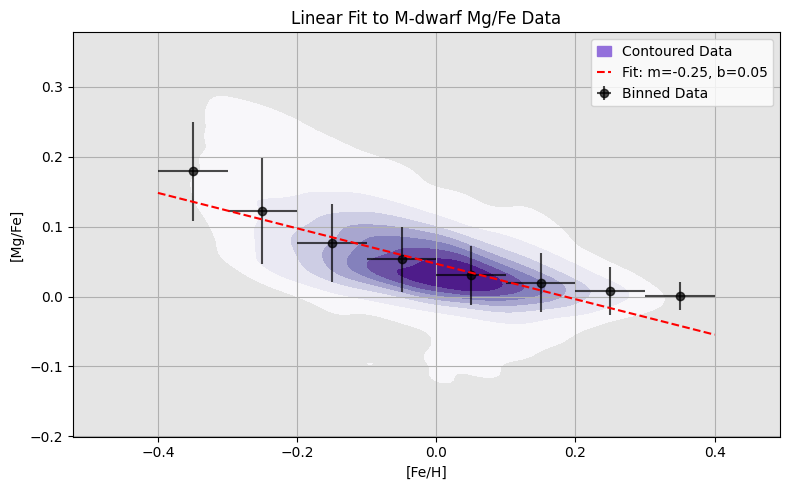

Reduced chi-squared: 3.404


In [ ]:
#initial guess
p1=[-0.25, 0.3]
poptl, pcovl = curve_fit(linear,data['fe_h_cannon'],data['mgfe'], sigma=data['mgfe_err'],absolute_sigma=True,p0=p1)
x_fit = np.linspace(-0.4, 0.4, 1000)
y_fitl = linear(x_fit, *poptl)

#create plot
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5')
#plot contour
sns.kdeplot(x=data['fe_h_cannon'],y=data['mgfe'],fill=True,cmap="Purples", levels=8, label = "Data", legend = True)
#plot binned data
plt.errorbar(bin_centers, bin_means,xerr=0.05, yerr=bin_std, fmt='o', color="black", alpha=0.7, label='Binned Data', zorder=99)
plt.plot(x_fit, y_fitl, label=f"Fit: m={poptl[0]:.2f}, b={poptl[1]:.2f}", color='red',linestyle="--", zorder=100)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("Linear Fit to M-dwarf Mg/Fe Data")
kde_patch = mpatches.Patch(color='mediumpurple', label='Contoured Data')
plt.legend(handles=[kde_patch] + plt.gca().get_legend_handles_labels()[0], loc="upper right", handlelength =1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

#Calculate reduced chi squared:
#create the y values from the model
y_model2 = linear(data['fe_h_cannon'], *poptl)

# Compute chi-squared
chi_squared = np.sum(((data['mgfe'] - y_model2) / data['mgfe_err'])**2)
# Compute degrees of freedom: number of data points - number of fitted parameters
dof = len(data['fe_h_cannon']) - 2

# Compute reduced chi-squared
reduced_chi_squared = chi_squared / dof
print(f"Reduced chi-squared: {reduced_chi_squared:.3f}")

## Appendix
Here are all of the plots and fits that we explored but ended up not using

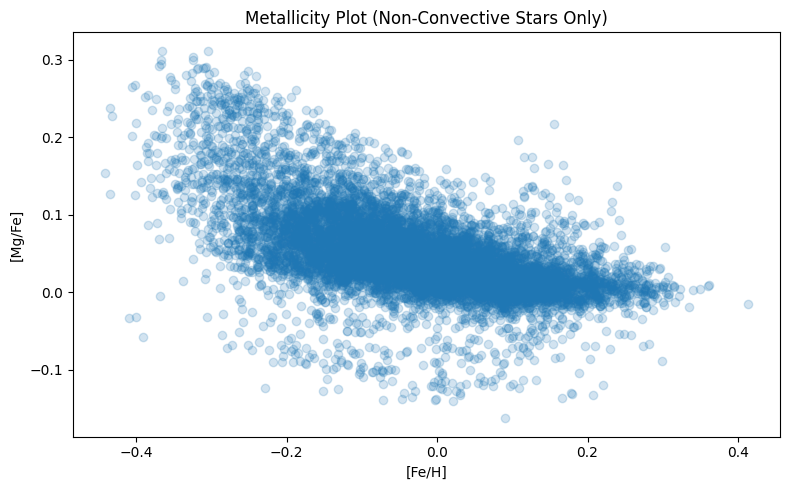

In [ ]:
#In conversation with Dr. Kim Ward-Duoug she mentioned exploring the temperature line between fully convective M dwarfs and non fully convective ones
convective_data0 = data[data['convective'] == 0]

# Create the plot
plt.figure(figsize=(8, 5))

plt.scatter(convective_data0['fe_h_cannon'], convective_data0['mgfe'],  alpha=0.2)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('Metallicity Plot (Non-Convective Stars Only)')
plt.tight_layout()
plt.show()

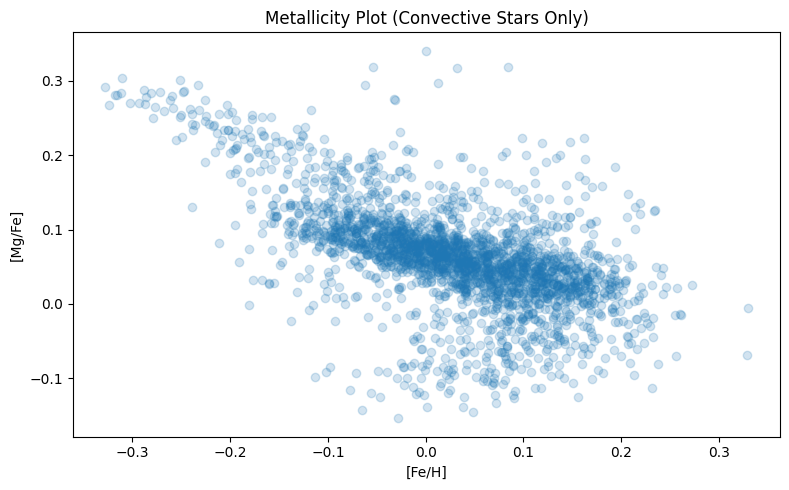

In [ ]:
# Filter the data
convective_data = data[data['convective'] == 1]

# Create the plot
plt.figure(figsize=(8, 5))

plt.scatter(
    convective_data['fe_h_cannon'], convective_data['mgfe'],  alpha=0.2
)
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.title('Metallicity Plot (Convective Stars Only)')
plt.tight_layout()
plt.show()


<ErrorbarContainer object of 3 artists>

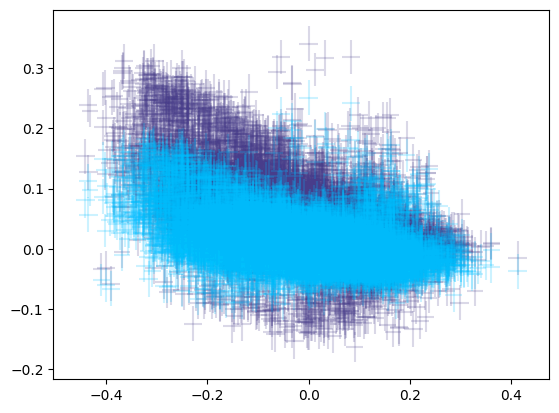

In [ ]:
#Comparing [Mg/Fe] and [O/Fe] scatters
ofe=data['o_h_cannon']-data['fe_h_cannon']
data['ofe']=ofe
data["ofe_err"]=np.sqrt(data["fe_h_err"]**2+data["o_h_err"]**2)
data = data[data['ofe_err'] <= 0.03]
plt.errorbar(data['fe_h_cannon'], data['mgfe'], xerr=data['fe_h_err'], yerr=data['mgfe_err'], fmt='none', color='darkslateblue', alpha=0.2)
plt.errorbar(data['fe_h_cannon'], data['ofe'], xerr=data['fe_h_err'], yerr=data['ofe_err'], fmt='none', color='deepskyblue', alpha=0.2)

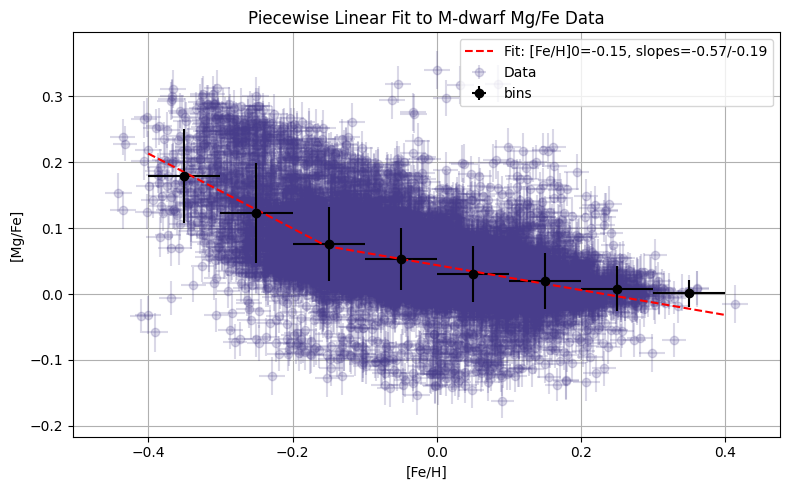

In [ ]:
# Initial guess
p0 = [0.0, 0.05, -0.5, -0.1]

# Fit the model to data
popt, pcov = curve_fit(piecewise_linear,data['fe_h_cannon'],data['mgfe'], sigma=data['mgfe_err'],absolute_sigma=True,p0=p0)

#create the bins
bin_centers, bin_means, bin_std, bin_edges = bin_data(data["fe_h_cannon"], data["mgfe"], bin_width=0.1, leastbin=20)

# create the best fit line within the linespace of the data
x_fit = np.linspace(-0.4, 0.4, 1000)
y_fit = piecewise_linear(x_fit, *popt)

# Plot a errorbar scatter plot of the data and plot the least squares fit on top
plt.figure(figsize=(8, 5))
plt.errorbar(data['fe_h_cannon'], data['mgfe'],xerr=data["fe_h_err"], yerr=data['mgfe_err'], fmt='o',color="darkslateblue", alpha=0.2, label='Data')

plt.errorbar(bin_centers, bin_means,xerr=0.05, yerr=bin_std, fmt='o',color="black", alpha=1, label='bins', zorder=100)
plt.plot(x_fit, y_fit, label=f"Fit: [Fe/H]0={popt[0]:.2f}, slopes={popt[2]:.2f}/{popt[3]:.2f}",linestyle="--", color='red', zorder=100)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.title("Piecewise Linear Fit to M-dwarf Mg/Fe Data")
plt.legend(loc = "upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

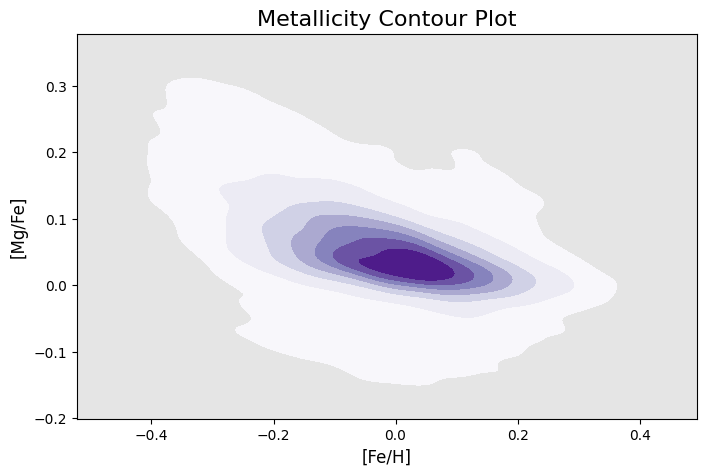

In [ ]:
plt.figure(figsize=(8, 5))
plt.gca().set_facecolor('#E5E5E5')

# Plot a 2D KDE contour plot
sns.kdeplot(x=data['fe_h_cannon'],y=data['mgfe'],fill=True,cmap="Purples", levels=8, thresh=0.01)

# Axis labels and title
plt.xlabel('[Fe/H]', fontsize=12)
plt.ylabel('[Mg/Fe]', fontsize=12)
plt.title('Metallicity Contour Plot', fontsize=16)
plt.show()